In [2]:
pip install opensmile

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import opensmile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

In [4]:


# -------------------------------
# Audio Feature Extraction (OpenSMILE)
# -------------------------------
columns_to_keep = ['pcm_zcr_sma', 'pcm_RMSenergy_sma', 'voicingFinalUnclipped_sma'] + \
                  [f'mfcc_sma[{i}]' for i in range(1, 13)] + ['file']

def process_file(file_path):
    """Load audio and extract low-level features using OpenSMILE."""
    signal, sr = librosa.load(file_path, sr=None)
    smile = opensmile.Smile(feature_set=opensmile.FeatureSet.ComParE_2016,
                            feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
    df = smile.process_signal(signal, sr)
    return df

def filter_features(df):
    """Keep only selected features."""
    return df[columns_to_keep]

def calculate_statistical_features(group):
    """Calculate statistical features for a group corresponding to one file."""
    stats = {}
    for column in group.columns:
        if column == 'file':
            continue
        data = group[column].dropna()
        if len(data) > 0:
            max_val = data.max()
            max_pos = np.argmax(data.values) / len(data)
            value_range = data.max() - data.min()
            median_val = data.median()
            kurtosis_val = kurtosis(data)
            skewness_val = skew(data)
            std_dev = data.std()

            x = np.arange(len(data))
            lin_reg_coef = np.polyfit(x, data, 1)
            quad_error = np.sum((np.polyval(lin_reg_coef, x) - data) ** 2)

            stats[column + '_max'] = max_val
            stats[column + '_max_pos'] = max_pos
            stats[column + '_range'] = value_range
            stats[column + '_median'] = median_val
            stats[column + '_kurtosis'] = kurtosis_val
            stats[column + '_skewness'] = skewness_val
            stats[column + '_std_dev'] = std_dev
            stats[column + '_lin_reg_coef_0'] = lin_reg_coef[0]
            stats[column + '_lin_reg_coef_1'] = lin_reg_coef[1]
            stats[column + '_quad_error'] = quad_error
    return pd.Series(stats)

def extract_audio_features(audio_path):
    """Extract fixed-length feature vector from an audio file using OpenSMILE."""
    df = process_file(audio_path)
    df['file'] = os.path.basename(audio_path)
    filtered_df = filter_features(df)
    stats_series = calculate_statistical_features(filtered_df)
    features = stats_series.values.astype(np.float32)
    return features

# -------------------------------
# Text Embedding (LaBSE)
# -------------------------------
LABSE_MODEL_NAME = "sentence-transformers/LaBSE"
labse_tokenizer = AutoTokenizer.from_pretrained(LABSE_MODEL_NAME)
labse_model = AutoModel.from_pretrained(LABSE_MODEL_NAME)
labse_model.eval()

def text_to_embedding(text):
    """Convert text to a fixed-length embedding using LaBSE."""
    inputs = labse_tokenizer(text,
                             add_special_tokens=True,
                             max_length=128,
                             padding='max_length',
                             truncation=True,
                             return_attention_mask=True,
                             return_tensors='pt')
    with torch.no_grad():
        outputs = labse_model(**inputs)
    # Use pooler output as the embedding
    embedding = outputs.pooler_output.squeeze(0)
    return embedding.float()

# -------------------------------
# MultiModal Dataset
# -------------------------------
class MultiModalDataset(Dataset):
    def __init__(self, audio_paths, texts, labels):
        """
        audio_paths: list of full paths to audio files.
        texts: list of corresponding transcriptions.
        labels: list or array of labels.
        """
        self.audio_paths = audio_paths
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # Extract audio features using OpenSMILE
        audio_feat = extract_audio_features(self.audio_paths[idx])
        audio_feat_tensor = torch.tensor(audio_feat)
        # Get text embedding using LaBSE
        text_emb = text_to_embedding(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'audio': audio_feat_tensor,
                'text': text_emb,
                'label': label}

# -------------------------------
# Late Fusion Classifier
# -------------------------------
class LateFusionClassifier(nn.Module):
    def __init__(self, audio_input_dim, text_input_dim, common_dim=256, num_classes=2):
        """
        audio_input_dim: Dimension of the OpenSMILE feature vector (e.g., 150).
        text_input_dim: Dimension of the LaBSE embedding (e.g., 768).
        common_dim: Dimension to project each modality.
        num_classes: Number of output classes.
        """
        super(LateFusionClassifier, self).__init__()
        # Audio branch: modality-specific transformation and classifier
        self.audio_fc = nn.Sequential(
            nn.LayerNorm(audio_input_dim),
            nn.Linear(audio_input_dim, common_dim),
            nn.ReLU()
        )
        self.audio_classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(common_dim, num_classes)
        )
        # Text branch: modality-specific transformation and classifier
        self.text_fc = nn.Sequential(
            nn.LayerNorm(text_input_dim),
            nn.Linear(text_input_dim, common_dim),
            nn.ReLU()
        )
        self.text_classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(common_dim, num_classes)
        )
    
    def forward(self, audio, text):
        # Process audio modality
        audio_proj = self.audio_fc(audio)
        audio_logits = self.audio_classifier(audio_proj)
        # Process text modality
        text_proj = self.text_fc(text)
        text_logits = self.text_classifier(text_proj)
        # Late fusion: combine predictions (here, we average the logits)
        fused_logits = (audio_logits + text_logits) / 2
        return fused_logits

# -------------------------------
# Training and Evaluation Functions
# -------------------------------
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for batch in dataloader:
        audio = batch['audio'].to(device)
        text = batch['text'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(audio, text)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * audio.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += audio.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc

def eval_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            audio = batch['audio'].to(device)
            text = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(audio, text)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * audio.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += audio.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    report = classification_report(all_labels, all_preds, target_names=['Non-Hate', 'Hate'])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return epoch_loss, epoch_acc, report, conf_matrix

def plot_confusion_matrix(matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Hate", "Hate"],
                yticklabels=["Non-Hate", "Hate"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()




tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [5]:
# -------------------------------
# Main Routine
# -------------------------------
def main():
    # Paths (update these paths as needed)
    excel_path = "/kaggle/input/binaryclass/TELUGU_METADATA_SHEETS.xlsx"
    hate_dir = "/kaggle/input/binaryclass/Hate"
    nonhate_dir = "/kaggle/input/binaryclass/Non Hate"
    
    # Load the dataset from Excel
    data_df = pd.read_excel(excel_path, sheet_name="BinaryClass")
    # Map labels: assume 'H' for Hate and 'NH' for Non-Hate
    data_df['CLASS LABEL'] = data_df['CLASS LABLE'].map({'H': 1, 'NH': 0})
    data_df = data_df.dropna(subset=['AUDIO FILE NAME', 'TRANSCRIPTION', 'CLASS LABLE'])
    
    audio_paths = []
    texts = []
    labels = []
    
    # For each row, assume the audio file name in Excel (may need extension adjustment)
    for idx, row in data_df.iterrows():
        file_name = str(row['AUDIO FILE NAME']).strip()
        # Check both hate and non-hate directories for the file (search by base name)
        found = False
        for directory in [hate_dir, nonhate_dir]:
            for fname in os.listdir(directory):
                base, ext = os.path.splitext(fname)
                if base.strip() == file_name and ext.lower() in ['.mp3', '.wav']:
                    audio_paths.append(os.path.join(directory, fname))
                    texts.append(str(row['TRANSCRIPTION']))
                    labels.append(int(row['CLASS LABEL']))
                    found = True
                    break
            if found:
                break
        if not found:
            print(f"Audio file not found for: {file_name}")
    
    if len(audio_paths) == 0:
        raise ValueError("No audio files found. Check file names and directory paths.")
    
    # Split into training and testing sets
    train_audio, test_audio, train_texts, test_texts, train_labels, test_labels = train_test_split(
        audio_paths, texts, labels, test_size=0.2, random_state=42, stratify=labels)
    
    train_dataset = MultiModalDataset(train_audio, train_texts, train_labels)
    test_dataset = MultiModalDataset(test_audio, test_texts, test_labels)
    
    BATCH_SIZE = 8
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # Model Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Dimensions: audio features dimension (e.g., 150) and text embedding dimension (768)
    audio_dim = 150  
    text_dim = 768
    model = LateFusionClassifier(audio_input_dim=audio_dim, text_input_dim=text_dim, common_dim=256, num_classes=2)
    model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    NUM_EPOCHS = 20
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        val_loss, val_acc, val_report, conf_matrix = eval_model(model, test_loader, loss_fn, device)
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")
        print("Classification Report:")
        print(val_report)
        plot_confusion_matrix(conf_matrix)
    
    torch.save(model.state_dict(), "late_fusion_model.pth")
    print("Model saved as late_fusion_model.pth")



Using device: cuda
Epoch 1/20 | Train Loss: 0.6318 | Train Acc: 0.6458


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.5838 | Validation Acc: 0.6529
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.00      0.00      0.00        42
        Hate       0.65      1.00      0.79        79

    accuracy                           0.65       121
   macro avg       0.33      0.50      0.40       121
weighted avg       0.43      0.65      0.52       121



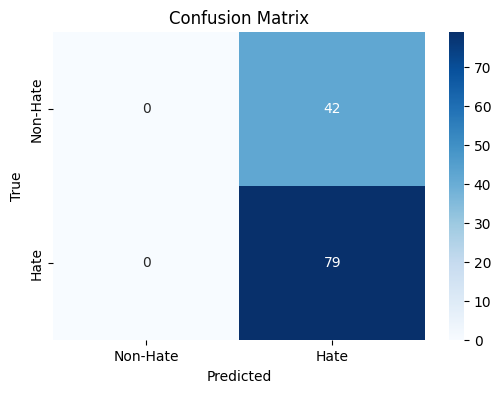

Epoch 2/20 | Train Loss: 0.5048 | Train Acc: 0.7292
Validation Loss: 0.4585 | Validation Acc: 0.7686
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       1.00      0.33      0.50        42
        Hate       0.74      1.00      0.85        79

    accuracy                           0.77       121
   macro avg       0.87      0.67      0.67       121
weighted avg       0.83      0.77      0.73       121



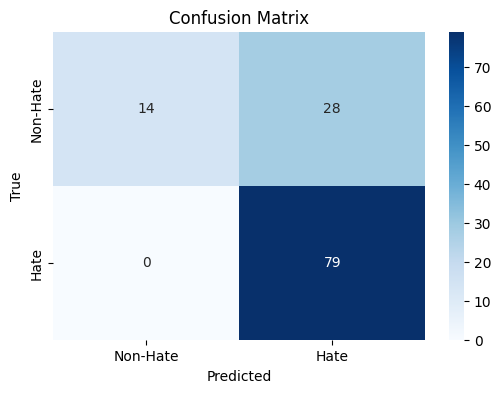

Epoch 3/20 | Train Loss: 0.3438 | Train Acc: 0.8979
Validation Loss: 0.3421 | Validation Acc: 0.8264
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.80      0.67      0.73        42
        Hate       0.84      0.91      0.87        79

    accuracy                           0.83       121
   macro avg       0.82      0.79      0.80       121
weighted avg       0.82      0.83      0.82       121



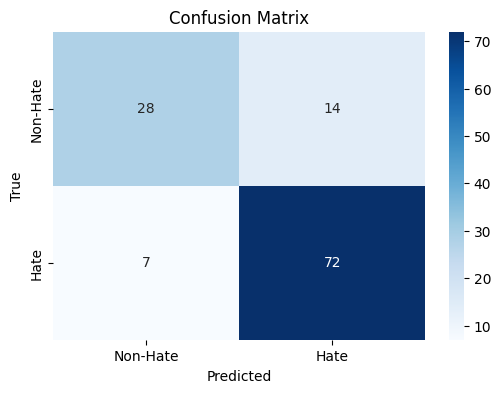

Epoch 4/20 | Train Loss: 0.2478 | Train Acc: 0.9187
Validation Loss: 0.3220 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.97      0.67      0.79        42
        Hate       0.85      0.99      0.91        79

    accuracy                           0.88       121
   macro avg       0.91      0.83      0.85       121
weighted avg       0.89      0.88      0.87       121



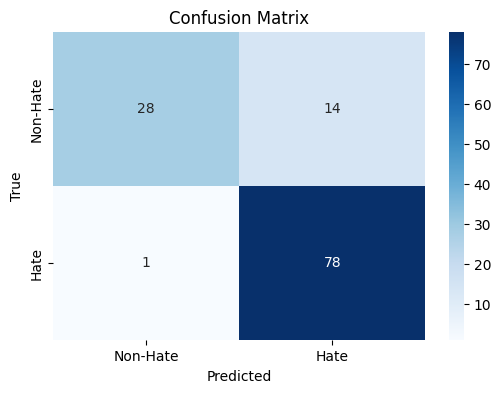

Epoch 5/20 | Train Loss: 0.1885 | Train Acc: 0.9313
Validation Loss: 0.3064 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.69      0.79        42
        Hate       0.86      0.97      0.91        79

    accuracy                           0.88       121
   macro avg       0.90      0.83      0.85       121
weighted avg       0.88      0.88      0.87       121



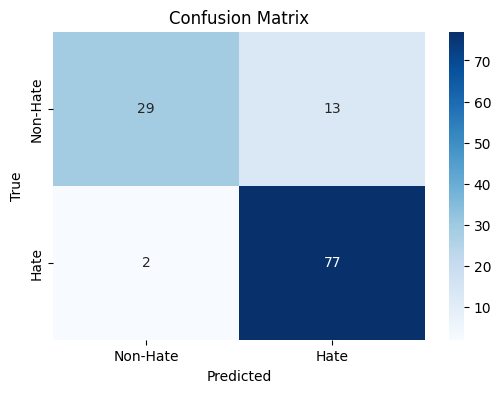

Epoch 6/20 | Train Loss: 0.1371 | Train Acc: 0.9625
Validation Loss: 0.3268 | Validation Acc: 0.8843
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.71      0.81        42
        Hate       0.87      0.97      0.92        79

    accuracy                           0.88       121
   macro avg       0.90      0.84      0.86       121
weighted avg       0.89      0.88      0.88       121



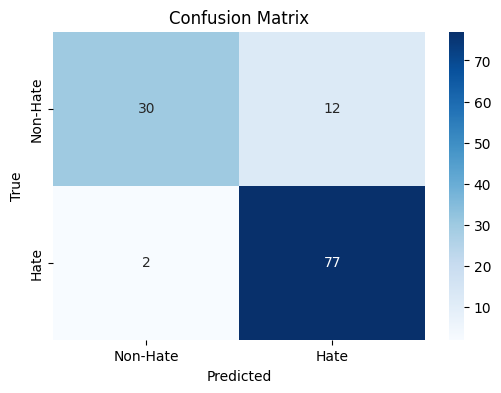

Epoch 7/20 | Train Loss: 0.0962 | Train Acc: 0.9792
Validation Loss: 0.3201 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.76      0.83        42
        Hate       0.88      0.96      0.92        79

    accuracy                           0.89       121
   macro avg       0.90      0.86      0.88       121
weighted avg       0.89      0.89      0.89       121



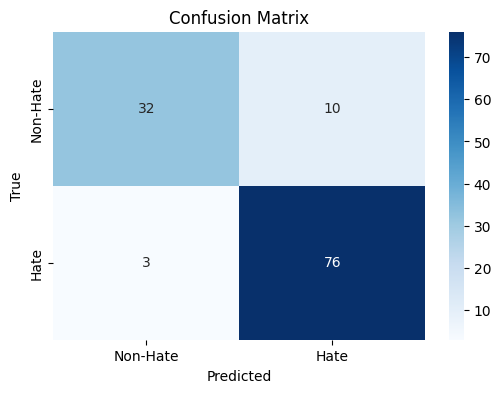

Epoch 8/20 | Train Loss: 0.0719 | Train Acc: 0.9833
Validation Loss: 0.3897 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.69      0.79        42
        Hate       0.86      0.97      0.91        79

    accuracy                           0.88       121
   macro avg       0.90      0.83      0.85       121
weighted avg       0.88      0.88      0.87       121



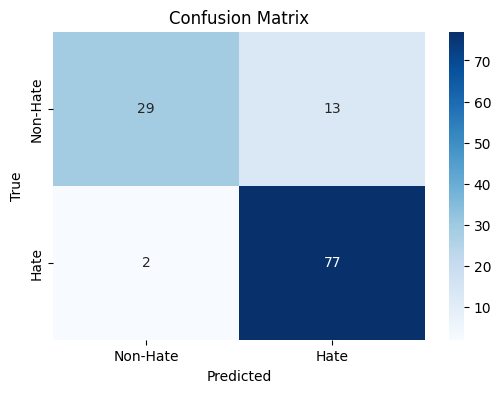

Epoch 9/20 | Train Loss: 0.0474 | Train Acc: 0.9938
Validation Loss: 0.3793 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.76      0.83        42
        Hate       0.88      0.96      0.92        79

    accuracy                           0.89       121
   macro avg       0.90      0.86      0.88       121
weighted avg       0.89      0.89      0.89       121



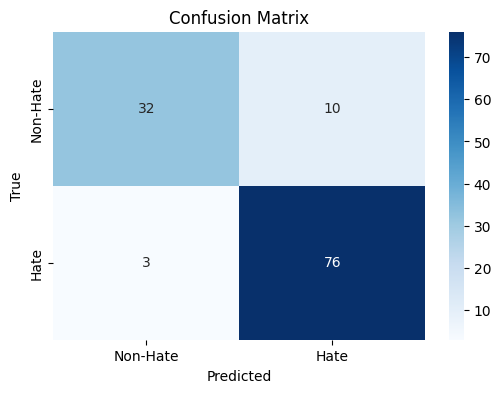

Epoch 10/20 | Train Loss: 0.0321 | Train Acc: 1.0000
Validation Loss: 0.4268 | Validation Acc: 0.8678
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.69      0.78        42
        Hate       0.85      0.96      0.90        79

    accuracy                           0.87       121
   macro avg       0.88      0.83      0.84       121
weighted avg       0.87      0.87      0.86       121



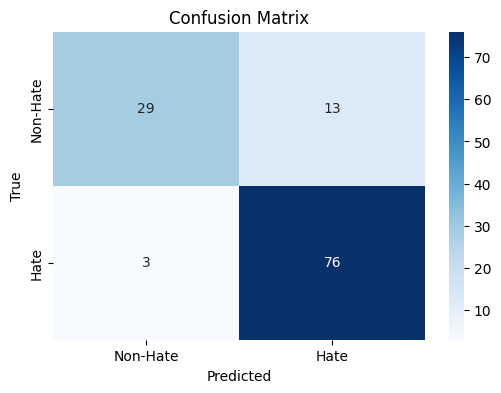

Epoch 11/20 | Train Loss: 0.0216 | Train Acc: 1.0000
Validation Loss: 0.4386 | Validation Acc: 0.8843
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.74      0.82        42
        Hate       0.87      0.96      0.92        79

    accuracy                           0.88       121
   macro avg       0.89      0.85      0.87       121
weighted avg       0.89      0.88      0.88       121



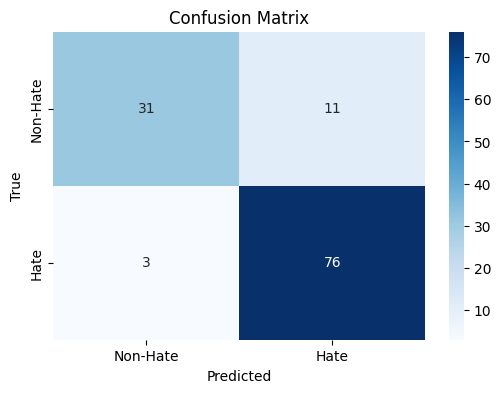

Epoch 12/20 | Train Loss: 0.0161 | Train Acc: 1.0000
Validation Loss: 0.4734 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.69      0.79        42
        Hate       0.86      0.97      0.91        79

    accuracy                           0.88       121
   macro avg       0.90      0.83      0.85       121
weighted avg       0.88      0.88      0.87       121



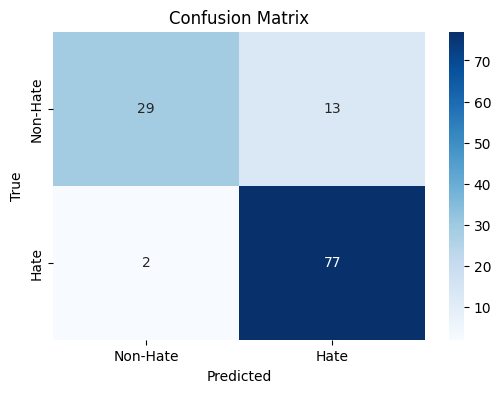

Epoch 13/20 | Train Loss: 0.0119 | Train Acc: 1.0000
Validation Loss: 0.4965 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.69      0.79        42
        Hate       0.86      0.97      0.91        79

    accuracy                           0.88       121
   macro avg       0.90      0.83      0.85       121
weighted avg       0.88      0.88      0.87       121



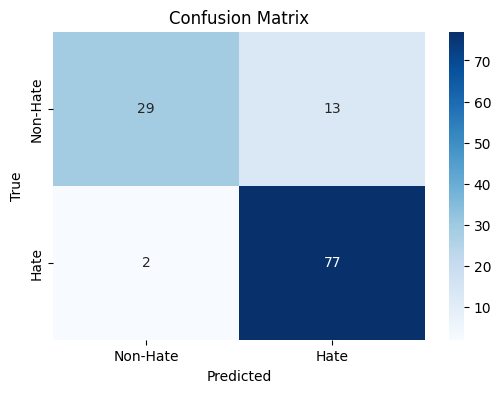

Epoch 14/20 | Train Loss: 0.0091 | Train Acc: 1.0000
Validation Loss: 0.5095 | Validation Acc: 0.8760
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.69      0.79        42
        Hate       0.86      0.97      0.91        79

    accuracy                           0.88       121
   macro avg       0.90      0.83      0.85       121
weighted avg       0.88      0.88      0.87       121



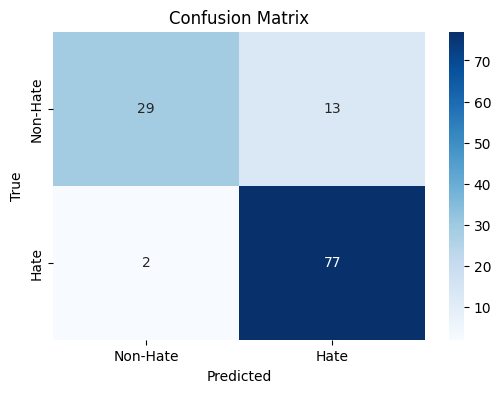

Epoch 15/20 | Train Loss: 0.0071 | Train Acc: 1.0000
Validation Loss: 0.5378 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.74      0.83        42
        Hate       0.88      0.97      0.92        79

    accuracy                           0.89       121
   macro avg       0.91      0.86      0.87       121
weighted avg       0.90      0.89      0.89       121



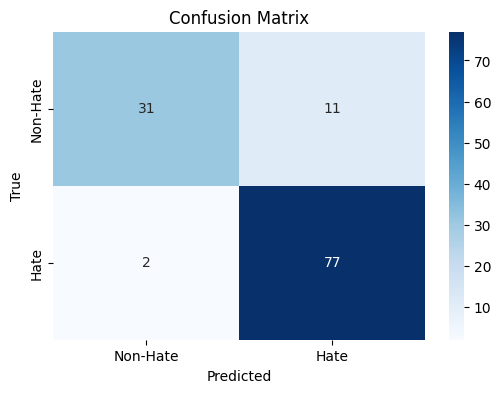

Epoch 16/20 | Train Loss: 0.0058 | Train Acc: 1.0000
Validation Loss: 0.5601 | Validation Acc: 0.8843
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.71      0.81        42
        Hate       0.87      0.97      0.92        79

    accuracy                           0.88       121
   macro avg       0.90      0.84      0.86       121
weighted avg       0.89      0.88      0.88       121



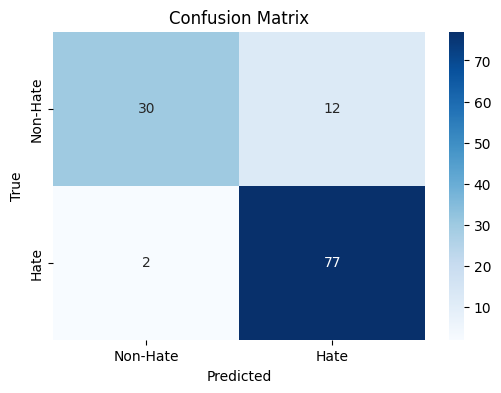

Epoch 17/20 | Train Loss: 0.0048 | Train Acc: 1.0000
Validation Loss: 0.5662 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.74      0.83        42
        Hate       0.88      0.97      0.92        79

    accuracy                           0.89       121
   macro avg       0.91      0.86      0.87       121
weighted avg       0.90      0.89      0.89       121



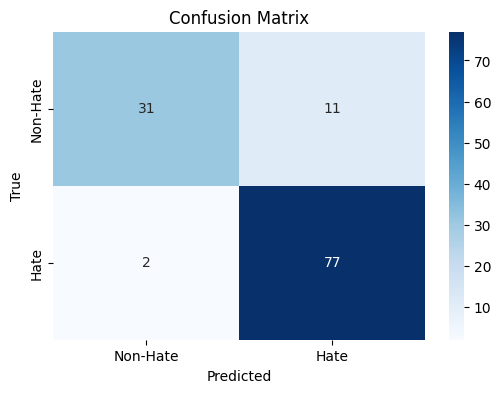

Epoch 18/20 | Train Loss: 0.0042 | Train Acc: 1.0000
Validation Loss: 0.5769 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.74      0.83        42
        Hate       0.88      0.97      0.92        79

    accuracy                           0.89       121
   macro avg       0.91      0.86      0.87       121
weighted avg       0.90      0.89      0.89       121



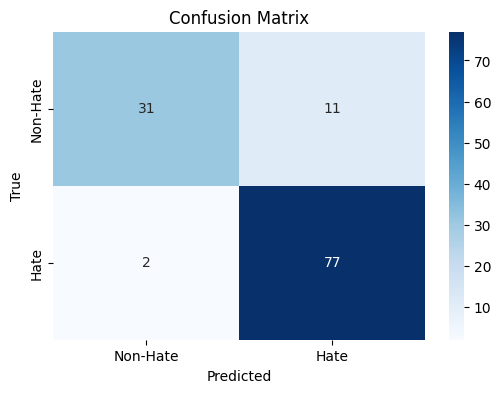

Epoch 19/20 | Train Loss: 0.0032 | Train Acc: 1.0000
Validation Loss: 0.5935 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.74      0.83        42
        Hate       0.88      0.97      0.92        79

    accuracy                           0.89       121
   macro avg       0.91      0.86      0.87       121
weighted avg       0.90      0.89      0.89       121



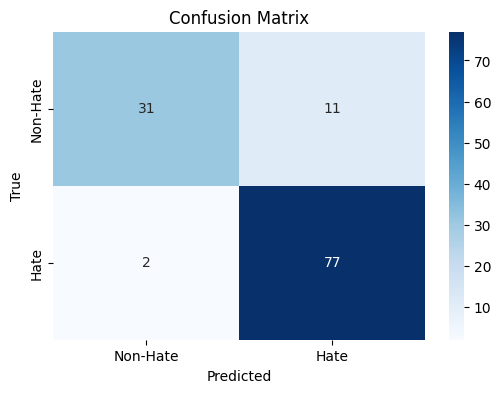

Epoch 20/20 | Train Loss: 0.0029 | Train Acc: 1.0000
Validation Loss: 0.6048 | Validation Acc: 0.8926
Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.94      0.74      0.83        42
        Hate       0.88      0.97      0.92        79

    accuracy                           0.89       121
   macro avg       0.91      0.86      0.87       121
weighted avg       0.90      0.89      0.89       121



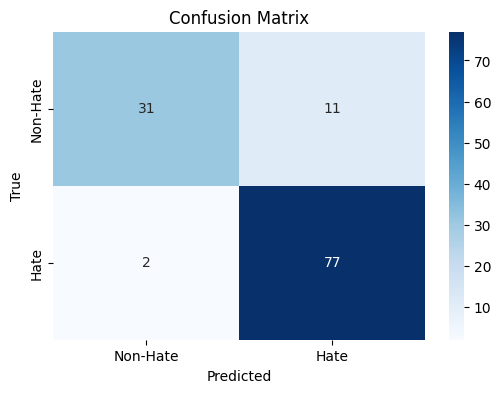

Model saved as late_fusion_model.pth


In [6]:
if __name__ == "__main__":
    main()